#  Прогнозирование заказов такси

<h1>Содержание<span class='tocSkip'></span></h1>

* [1 Подготовка](#my_section_1) <a id='content_1'></a>
* [2 Анализ](#my_section_2) <a id='content_2'></a>
  * [2.1 Апроксимация значений](#my_section_3) <a id='content_3'></a>
  * [2.2 Анализ временных рядов](#my_section_4) <a id='content_4'></a>
    * [2.2.1 Trend](#my_section_5) <a id='content_5'></a>
    * [2.2.2 Seasonality](#my_section_6) <a id='content_6'></a>
    * [2.2.3 Residuals](#my_section_7) <a id='content_7'></a>
  * [2.3 Заключение](#my_section_8) <a id='content_8'></a>
* [3 Работа с признаками](#my_section_9) <a id='content_9'></a>
  * [3.1 Создание признаков](#my_section_10) <a id='content_10'></a>
  * [3.2 Подготовка признаков](#my_section_11) <a id='content_11'></a>
* [4 Обучение](#my_section_12) <a id='content_12'></a>
  * [4.1 LinearRegression](#my_section_13) <a id='content_13'></a>
  * [4.2 LightGBM](#my_section_14) <a id='content_14'></a>
  * [4.3 RandomForestRegressor](#my_section_15) <a id='content_15'></a>
  * [4.4 Заключение](#my_section_16) <a id='content_16'></a>
* [5 Тестирование](#my_section_17) <a id='content_17'></a>
* [6 Вывод](#my_section_18) <a id='content_18'></a>



**Цель**:
Спрогнозировать количество заказов такси на следующий час.

**Критерий заказчика**:
- тестовая выборка размером 10% от исходных данных;
- значение метрики RMSE на тестовой выборке должно быть не больше 48.


**План работы**:
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**:
1. Имеется файл с историческими данными о заказах такси в аэропортах.
2. Данные лежат в файле taxi.csv. 
3. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).




<a id='my_section_1'></a>
## [Подготовка](#content_1)

Произведём импорт основных библиотек и модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

Определим функцию для загрузки файла

In [2]:
def download_file(name):
    """
    Функция проходит по возможным директориям 
    в попытке найти файл, используя конструкции
    try, except и итераторы. Возвращая прочтённый 
    файл или ошибку, если файл не найден.
    """
    def read(name):
        next_step = next(step)
        print(f'Пробую найти файл в {next_step}: {directory[next_step]}.')
        return pd.read_csv(directory[next_step] + name + '.csv', index_col=[0], parse_dates=[0])
    
    def error(err):
        print(f'Возникла ошибка: {err}\n')
        
    directory = {'windows':'', 'linux':'/datasets/', 'Internet':'https://..'}
    step = iter(directory)
    
    try:
        data = read(name)
    except FileNotFoundError as err:
        error(err)
        try:
            data = read(name)
        except FileNotFoundError as err:
            error(err)
            try:
                data = read(name)
            except FileNotFoundError:
                return error(err)
            
    print('Успех!')            
    return data           

Получим файл

In [3]:
data = download_file('taxi')

Пробую найти файл в windows: .
Успех!


Изучим файл

In [4]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.tail(5)

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


*Данные представлены за период с марта по август и формировались интервалом в 10 минут*

Проверим в хронологическом ли порядке расположены даты и время

In [6]:
print(data.index.is_monotonic)

True


Оценим значения

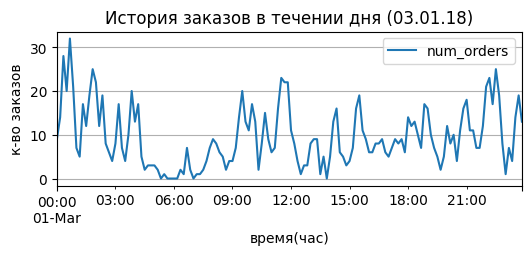

In [7]:
data['2018-03-01':'2018-03-01'].plot(figsize=(6,2), grid=True,
                                     xlabel='время(час)', ylabel='к-во заказов',
                                     title='История заказов в течении дня (03.01.18)');

Произведём ресемплирование по одному часу и по одному дню

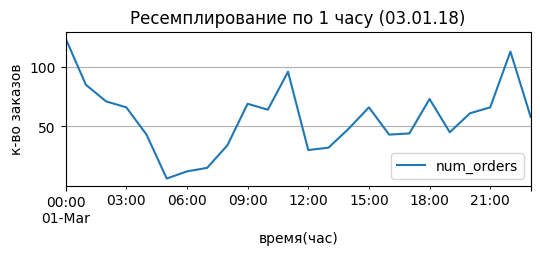

In [8]:
data = data.resample('1H').sum()
data_d = data.resample('1D').sum()
data['2018-03-01':'2018-03-01'].plot(figsize=(6,2), grid=True,
                                     xlabel='время(час)', ylabel='к-во заказов',
                                     title='Ресемплирование по 1 часу (03.01.18)');

**Заключение**: <br/>
Проведено ряд мер подготовки данных:
- загрузка библиотек, файла с данными;
- первичный осмотр, где выяснилось, что данные представлены за период с марта по август;
- сделано ресемплирование по одному часу.

<a id='my_section_2'></a>
## [Анализ](#content_2)

<a id='my_section_3'></a>
### [Апроксимация значений](#content_3)

Изучим полученые данные

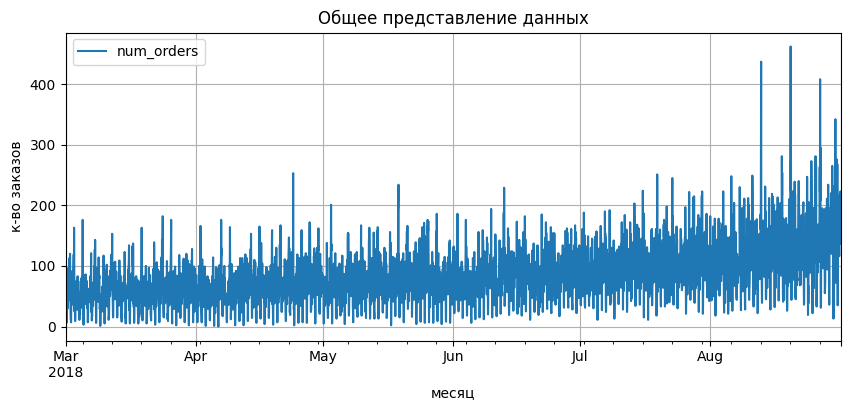

In [9]:
data.plot(figsize=(10,4), grid=True,
          xlabel='месяц', ylabel='к-во заказов',
          title='Общее представление данных');

Оценим скользящее среднее для оценки динамики

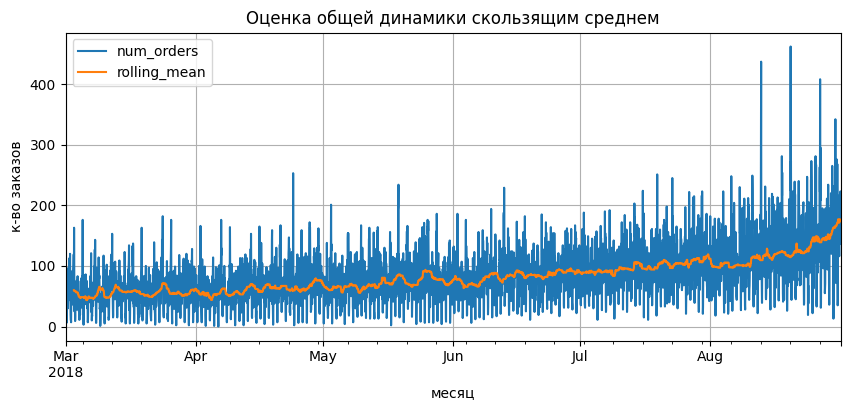

In [10]:
data['rolling_mean'] = data.rolling(48).median()
data.plot(figsize=(10,4), grid=True,
          xlabel='месяц', ylabel='к-во заказов',
          title='Оценка общей динамики скользящим среднем');

*Скользящее среднее определено интервало в 48 часов, таким образом заметно, что имеется тенденция на увеличение заказов в конце августа, а также в целом количество заказов растёт с марта по август. В целом заметно, что существует резкое увеличчение заказов в определённые промежутки времени.*

<a id='my_section_4'></a>
### [Анализ временных рядов](#content_4)

Чтобы лучше понимать временной ряд, разберём тренды и сезонность

In [11]:
data = data.drop('rolling_mean', axis=1)

In [12]:
decomposed = seasonal_decompose(data)
decomposed_d = seasonal_decompose(data_d)

<a id='my_section_5'></a>
#### [Trend](#content_5)

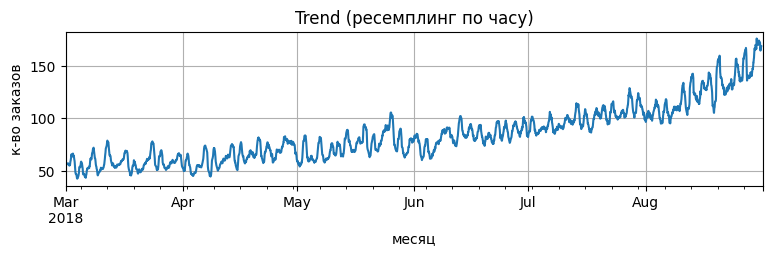

In [13]:
decomposed.trend.plot(figsize=(9, 2), grid=True, title = 'Trend (ресемплинг по часу)',
                      xlabel='месяц', ylabel='к-во заказов');

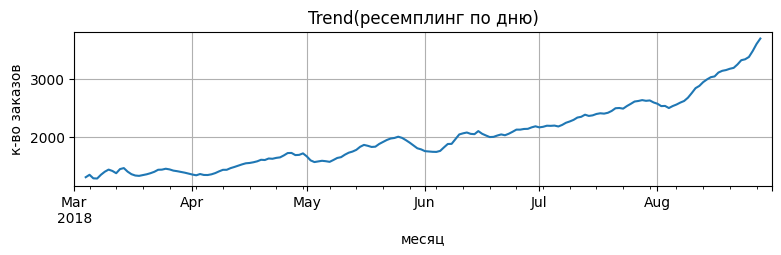

In [14]:
decomposed_d.trend.plot(figsize=(9, 2), grid=True, title = 'Trend(ресемплинг по дню)',
                        xlabel='месяц', ylabel='к-во заказов'); 

*На графиках можно более явно наблюдать тенденцию к увеличению заказов. Временной ряд относится к нестационарным*

<a id='my_section_6'></a>
#### [Seasonality](#content_6)

Изучим сезонную составляющую

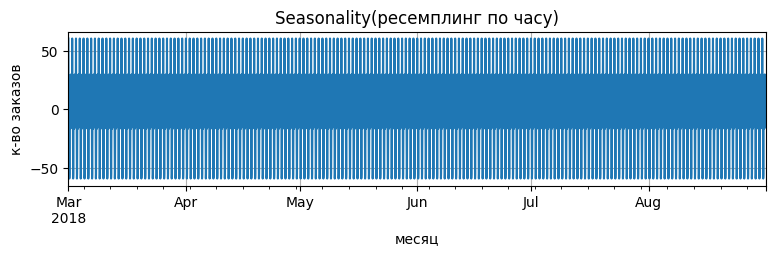

In [15]:
decomposed.seasonal.plot(figsize=(9, 2), grid=True, title = 'Seasonality(ресемплинг по часу)',
                         xlabel='месяц', ylabel='к-во заказов');

Уменьшим масштаб и разберём 15 дней марта месяца

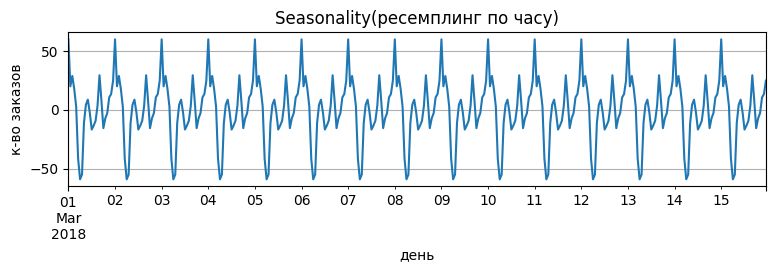

In [16]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(figsize=(9, 2), grid=True, title = 'Seasonality(ресемплинг по часу)',
                                                    xlabel='день', ylabel='к-во заказов');

*Заметно, что изо дня в день наблюдается цикличность в закзах. Разберём подробнее.*

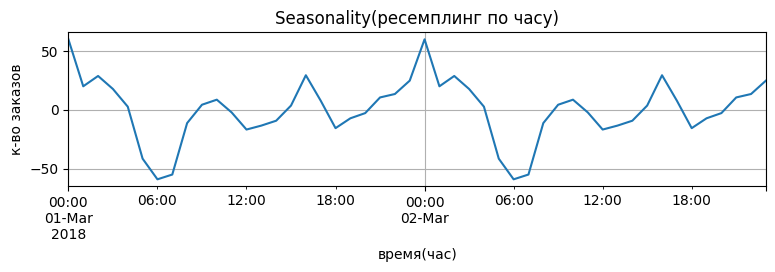

In [17]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(9, 2), grid=True, title = 'Seasonality(ресемплинг по часу)',
                                                    xlabel='время(час)', ylabel='к-во заказов');

*Можно предположить, что работники аэропорта пользуются услугами такси, после окончания смены или во время перерывов.*

Оценим сезонность с использованием ресемплирования по одному дню

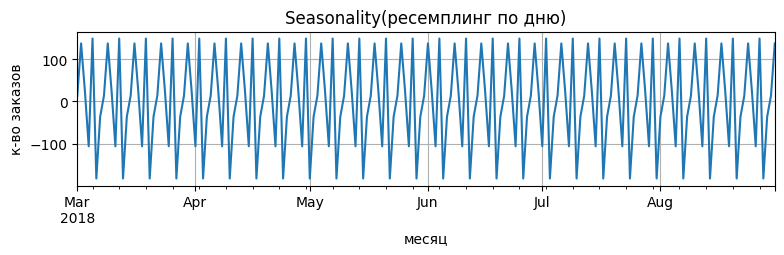

In [18]:
decomposed_d.seasonal.plot(figsize=(9, 2), grid=True, title = 'Seasonality(ресемплинг по дню)',
                          xlabel='месяц', ylabel='к-во заказов');

*Цикличность имеется на всем интервале*

<a id='my_section_7'></a>
#### [Residuals](#content_7)

Посмотрим на остаток от декомпозиции, используя разные ресемплинги и разное время

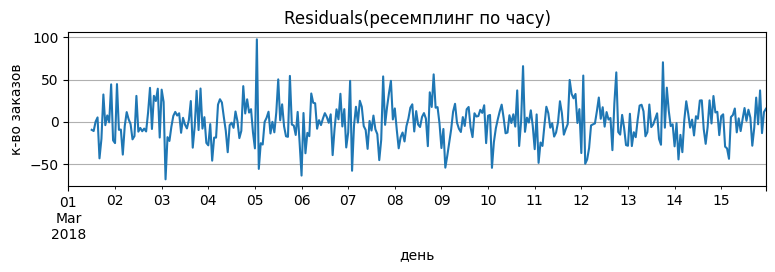

In [19]:
decomposed.resid['2018-03-01':'2018-03-15']\
.plot(figsize=(9, 2), grid=True, title = 'Residuals(ресемплинг по часу)',
      xlabel='день', ylabel='к-во заказов');

*Наблюдаются пики активности в разные дни марта. Посмотрим, что получится узнать, если использовать однодневный ресемплинг.*

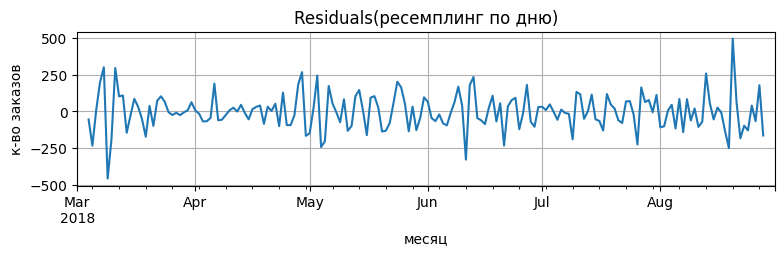

In [20]:
decomposed_d.resid\
.plot(figsize=(9, 2), grid=True, title = 'Residuals(ресемплинг по дню)',
      xlabel='месяц', ylabel='к-во заказов');

*Можно судить о пиках в разные месяцы, вероятно, вызванные уходами в отпуска. Веротяно, дать лучшую оценку позволит метод `rolling`.*

Изучим шум за первые 30 дней марта. 

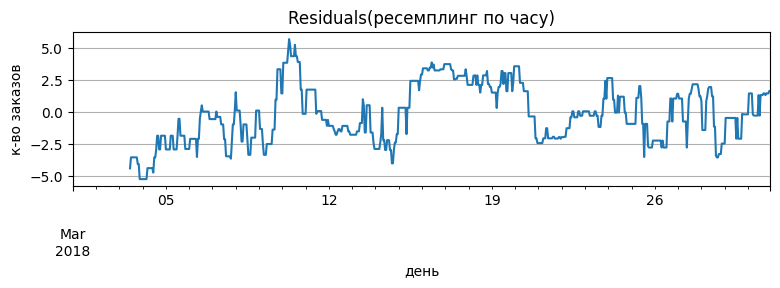

In [21]:
decomposed.resid['2018-03-01':'2018-03-30'].rolling(48).median()\
.plot(figsize=(9, 2), grid=True, title = 'Residuals(ресемплинг по часу)',
      xlabel='день', ylabel='к-во заказов');

*Используя `rolling` по 2 дням, не удалось наглядно наблюдать скачкообразность, полученную на мелкомасштабном графике выше. Вероятно, что такой результат получается, благодаря нескольким пикам с 05.03 по 12.03. В целом необходимость прогнозирования, изучая подобные графики более чем оправдана.*

Используем ресемплинг по 1 дню и посмотрим на результат для всего набора данных. Апроксимируем значения по 3 дням.

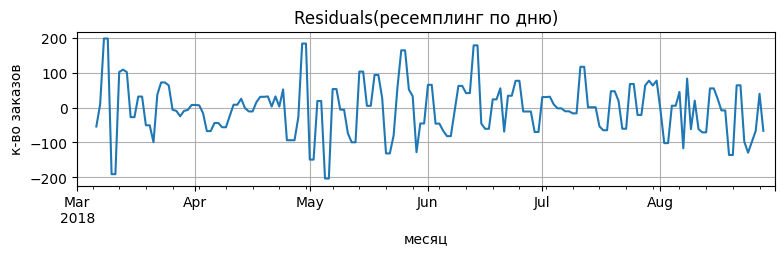

In [22]:
decomposed_d.resid.rolling(3).median()\
.plot(figsize=(9, 2), grid=True, title = 'Residuals(ресемплинг по дню)',
     xlabel='месяц', ylabel='к-во заказов');

*Полученный результат говорит о непостоянной активности и о критичной необходимости в динамическом распределении таксистов во времена пиковой нагрузки.*

<a id='my_section_8'></a>
### [Заключение](#content_8)

Предварительный осмотр выявил, что имеется тенденция на увеличение заказов в конце августа, а также в целом количество заказов растёт с марта по август, т.е. необходимо привести набор данных к стационарному виду. В целом заметно, что существует резкое увеличение заказов в определённые промежутки времени. Анализ временных рядов дал следующие результаты:
- Тренд: подтвердилась динамика увеличения заказов с марта по август.;
- Сезонность: обнаружилась закономерность, соблюдающаяся на всём промежутке времени, предположительно, причиной являются сотрудники аэропорта.
- Остаток декомпозиции: предположительно, этот остаток составляют граждане, отправляющиеся в отпуска или по иным причинам в путешествие. 

<a id='my_section_9'></a>
## [Работа с признаками](#content_9)

Проведём ряд мероприятий для подготовки к обучению

<a id='my_section_10'></a>
### [Создание признаков](#content_10)

Определим функцию для увеличения количества признаков

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).median()
    return new_data


data = make_features(data, 24, 24)

In [24]:
data.head(5)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='my_section_11'></a>
### [Подготовка признаков](#content_11)

Определим функцию для разделение выборки на обучающие признаки и целевой

In [25]:
def split_into_signs(sign):
    features_train = sign.drop('num_orders', axis=1)
    target_train = sign['num_orders']
    return features_train, target_train

Определим функцию для контроля значений

In [26]:
def check_val_signs():
    dict_signs = {'features_train':train, 'features_valid':valid, 'features_test':test}
    print('Количество объектов в выборках')
    for key, val in dict_signs.items():
        print(f'{key}: {val.shape[0]} {val.shape[0]/data.shape[0] :.2f}')

Разделим набор данных на выборки, ориентируясь на критерий.

In [27]:
train, valid = train_test_split(data, shuffle=False, test_size=.4)
valid, test = train_test_split(valid, shuffle=False, test_size=.25)
train = train.dropna()

Определим обучающий и целевой признак

In [28]:
features_train, target_train = split_into_signs(train)
features_valid, target_valid = split_into_signs(valid)
features_test, target_test = split_into_signs(test)

In [29]:
check_val_signs()

Количество объектов в выборках
features_train: 2625 0.59
features_valid: 1325 0.30
features_test: 442 0.10


<a id='my_section_12'></a>
## [Обучение](#content_12)

<a id='my_section_13'></a>
### [LinearRegression](#content_13)

In [30]:
model = LinearRegression()

In [31]:
%%time
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
print('RMSE', rmse)

RMSE 30.578585679522877
CPU times: total: 15.6 ms
Wall time: 8.98 ms


<a id='my_section_14'></a>
### [LightGBM](#content_14)

In [32]:
# Создание датасета
train_dataset = lgb.Dataset(features_train, target_train, feature_name=features_train.columns.tolist())                    
valid_dataset = lgb.Dataset(features_valid, target_valid, feature_name=features_valid.columns.tolist())               

In [33]:
%%time
best_lgbm_rmse = 100
for lea in range(15, 40, 1):
    for depth in range(3, 17, 1):
        # Определение параметров модели
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': lea,
            'max_depth':depth,
            'learning_rate': 0.05,
            'verbose': -1
        }

        # Обучение модели
        booster = lgb.train(params, train_set=train_dataset, valid_sets=[train_dataset, valid_dataset],
                            num_boost_round=500, callbacks=[lgb.log_evaluation(period=100),lgb.early_stopping(10)])
        
        valid_prediction = booster.predict(features_valid)
        result = mean_squared_error(target_valid, valid_prediction)**0.5
        
        if result <= best_lgbm_rmse:
            best_lgbm_rmse = result
            best_lgbm_model = booster
            best_lgbm_params = params
        
    

Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 19.09	valid_1's rmse: 33.1792
[200]	training's rmse: 17.4825	valid_1's rmse: 32.4153
Early stopping, best iteration is:
[279]	training's rmse: 16.6401	valid_1's rmse: 31.9615
Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 17.3646	valid_1's rmse: 32.4466
Early stopping, best iteration is:
[172]	training's rmse: 15.9694	valid_1's rmse: 31.4448
Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 16.5016	valid_1's rmse: 32.2394
[200]	training's rmse: 14.125	valid_1's rmse: 31.4601
Early stopping, best iteration is:
[207]	training's rmse: 13.9707	valid_1's rmse: 31.374
Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 16.224	valid_1's rmse: 32.202
Early stopping, best iteration is:
[137]	training's rmse: 15.1292	valid_1's rmse: 31.7234
Training until validation scores don't improve for 10 rounds
[100]	train

In [34]:
print('\nЛучшее RMSE модели LightGBM:', best_lgbm_rmse,
      f'\n\nЛучшие параметры')

for key, val in best_lgbm_params.items():
    print(f'{key}: {val}')


Лучшее RMSE модели LightGBM: 30.996311257405136 

Лучшие параметры
objective: regression
metric: rmse
boosting_type: gbdt
num_leaves: 20
max_depth: 9
learning_rate: 0.05
verbose: -1


<a id='my_section_15'></a>
### [RandomForestRegressor](#content_15)

In [35]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(20, 30, 2):
    for depth in range (4, 7):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model_rf.fit(features_train, target_train) 
        predictions_valid = model_rf.predict(features_valid) 
        result_rfr = mean_squared_error(target_valid, predictions_valid)**0.5 
        if result_rfr < best_result:
            best_model_rf = model_rf
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result,
      "\nКоличество деревьев:", best_est, "\nМаксимальная глубина:", depth)

RMSE наилучшей модели на валидационной выборке: 31.40073155615973 
Количество деревьев: 20 
Максимальная глубина: 6


<a id='my_section_16'></a>
### [Заключение](#content_16)

Было проведено три эксперимента в результате которых модели показали точность RMSE:
- LinearRegression: 30.578585679522877;
- LightGBM: 30.996311257405136;
- RandomForestRegressor: 31.40073155615973.<br/>

В результате выбрана LinearRegression как лучшая. Используем её для проведения теста.






<a id='my_section_17'></a>
## [Тестирование](#content_17)

Используем лучшую модель LinearRegression `model` для предсказания на тестовой выборке.

In [36]:
%%time
test_prediction = model.predict(features_test)
result_test_rmse = mean_squared_error(target_test, test_prediction) ** 0.5
print(f'RMSE лучшей модели на тестовой выборке: {result_test_rmse}')

RMSE лучшей модели на тестовой выборке: 46.88952338650032
CPU times: total: 15.6 ms
Wall time: 1.99 ms


Получим дополнительное представление о качестве модели на графике

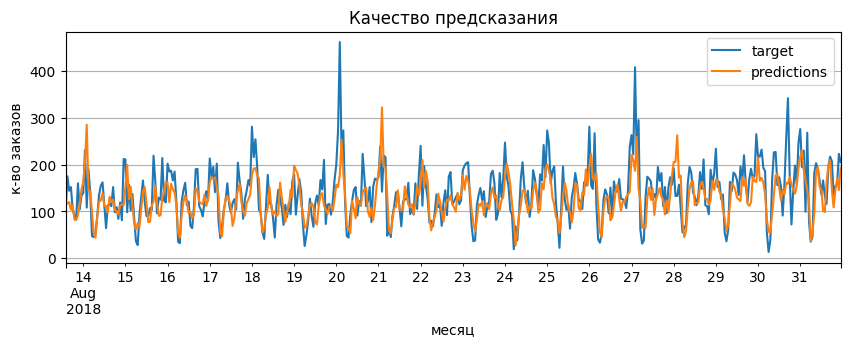

In [37]:
result_plot = pd.DataFrame({'target':target_test, 'predictions':test_prediction}, index=features_test.index)
result_plot.plot(figsize=(10, 3), grid=True, title = 'Качество предсказания',
                         xlabel='месяц', ylabel='к-во заказов');

Уменьшим масштаб для наглядности

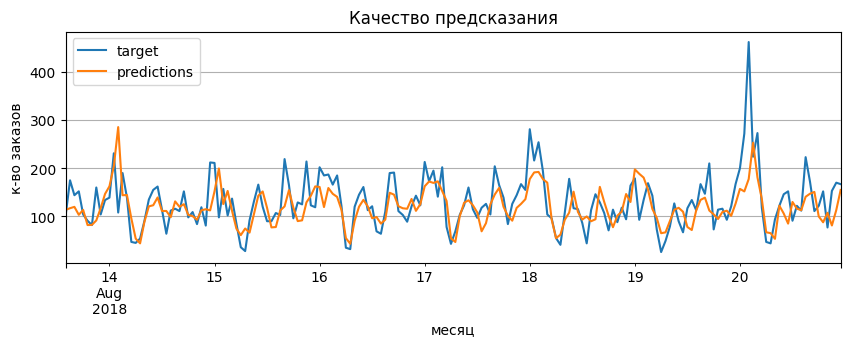

In [38]:
result_plot['2018-08-13': '2018-08-20'].plot(figsize=(10, 3), grid=True, title = 'Качество предсказания',
                         xlabel='месяц', ylabel='к-во заказов');

*Результат можно считать успешным. Модель совершает предсказания с удовлетворяющей для заказчика точностью.*

<a id='my_section_18'></a>
## [Вывод](#content_18)

Для решения поставленной задачи был предпринят ряд мер:
1. Подготовка:
    - была осуществлена загрузка библиотек и модулей, данных. Данные переданы в нужном виде и формате;
    - проведён первичный осмотр, показавший, что данные представлены с марта по август 2018 года;
    - выполнено ресемплирование по 1 часу и 1 дню. 


2. Анализ показал:
    - что имеется общая тенденция к увеличению заказов с марта по август, набор данных не относится к стационарному виду;
    - Trend подтвердил предположение об общей тенденции к увеличению заказов;
    - в Seasonality обнаружилась закономерность, соблюдающаяся на всём промежутке времени, предположительно, причиной являются сотрудники аэропорта или других служб вблизи;
    - Residuals достаточно хаотично распределён, с резкими выбросами и падениями на промежутках, предположительно, этот остаток составляют граждане, отправляющиеся в отпуска или по иным причинам в путешествие.
    
    
3. В результатае подготовки признаков:
    - проведена работа создания признаков по исходным данным;
    - данные разделены на обучающую, валидационную, тестовую выборки;
    - осуществлена подготовка признаков в соответствии с критерием заказчика (тестовый набор данных составляет 10% от выборки).
    
    
4. Проведено обучение моделей, которые показали точноть RMSE:
    - LinearRegression: 30.578585679522877;
    - LightGBM: 30.996311257405136;
    - RandomForestRegressor: 31.40073155615973.
    
    
5. По результату сравнения моделей была выбранна лучшая: LightGBM. Осуществлена проверка точности на тестовой выборке критерием RMSE:
    - 46.88952338650032.
    
    
Результат проделанной работы — обученная модель, способная спрогнозировать количество заказов такси на следующий час с точность, удовлетворяющей критерию заказчика.    